In [1]:
# Imports
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder

import numpy as np
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve, f1_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d

from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [46]:
train_data = ImageFolder(root='/content/drive/My Drive/KAIST/CS470/Project_2/splitted/train', transform=transform)
val_data = ImageFolder(root='/content/drive/My Drive/KAIST/CS470/Project_2/splitted/validation', transform=transform)
test_data = ImageFolder(root='/content/drive/My Drive/KAIST/CS470/Project_2/splitted/test', transform=transform)

In [47]:
# Creating data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [48]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
            #nn.Sigmoid()
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Pass the input through the fully connected layers
        x = self.fc_layers(x)
        #print(x.shape)
        return x

# Create the VGG16 model
model = VGG16().to(device)

class_weights = [1.0 / count for count in [1372, 5797]]
class_weights = torch.FloatTensor(class_weights).to(device)

# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_accuracy = total_train_correct / len(train_loader.dataset)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_correct = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_accuracy = total_val_correct / len(val_loader.dataset)
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model if required
        torch.save(model.state_dict(), '/content/drive/My Drive/KAIST/CS470/Project_2/best_model_vgg16_final.pth')

    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break  # Early stopping

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch 1/10 - Validation: 100%|██████████| 24/24 [00:11<00:00,  2.16it/s]


Epoch 1/10, Train Loss: 0.0112, Train Acc: 0.6283, Val Loss: 0.0106, Val Acc: 0.7936


Epoch 2/10 - Validation: 100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


Epoch 2/10, Train Loss: 0.0109, Train Acc: 0.8019, Val Loss: 0.0108, Val Acc: 0.7936


Epoch 3/10 - Validation: 100%|██████████| 24/24 [00:11<00:00,  2.16it/s]


Epoch 3/10, Train Loss: 0.0109, Train Acc: 0.7485, Val Loss: 0.0106, Val Acc: 0.7936


Epoch 4/10 - Validation: 100%|██████████| 24/24 [00:10<00:00,  2.18it/s]


Epoch 4/10, Train Loss: 0.0109, Train Acc: 0.7779, Val Loss: 0.0108, Val Acc: 0.7936


Epoch 5/10 - Validation: 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


Epoch 5/10, Train Loss: 0.0109, Train Acc: 0.5620, Val Loss: 0.0105, Val Acc: 0.7936


Epoch 6/10 - Validation: 100%|██████████| 24/24 [00:11<00:00,  2.18it/s]


Epoch 6/10, Train Loss: 0.0109, Train Acc: 0.6082, Val Loss: 0.0108, Val Acc: 0.7936


Epoch 7/10 - Validation: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


Epoch 7/10, Train Loss: 0.0109, Train Acc: 0.7525, Val Loss: 0.0107, Val Acc: 0.7936


Epoch 8/10 - Validation: 100%|██████████| 24/24 [00:10<00:00,  2.21it/s]


Epoch 8/10, Train Loss: 0.0109, Train Acc: 0.7797, Val Loss: 0.0106, Val Acc: 0.7936


Epoch 9/10 - Validation: 100%|██████████| 24/24 [00:10<00:00,  2.34it/s]


Epoch 9/10, Train Loss: 0.0109, Train Acc: 0.8060, Val Loss: 0.0106, Val Acc: 0.7936


Epoch 10/10 - Validation: 100%|██████████| 24/24 [00:11<00:00,  2.17it/s]

Early stopping triggered after 10 epochs


In [50]:
# Accuracy, EER, and TAR at specific FAR
def calculate_metrics(labels, scores, far_target=1e-3):
    labels = np.array(labels)
    scores = np.array(scores)  # Keep it as 1D if your model only outputs one probability per example
    fpr, tpr, thresholds = roc_curve(labels, scores)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    far_index = np.where(fpr <= far_target)[0][-1]
    tar_at_far = tpr[far_index]
    accuracy = accuracy_score(labels, scores > 0.5)  # Directly use scores as 1D array
    return accuracy, eer, tar_at_far

# Testing Loop
model.eval()
all_labels = []
all_scores = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #print("Raw model outputs:", outputs)
        #break  # Remove break to see more batches

        # Convert logits to probabilities using softmax for CrossEntropyLoss
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
        all_scores.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print metrics
accuracy, eer, tar_at_far = calculate_metrics(all_labels, all_scores)
print(f'Accuracy: {accuracy:.4f}, EER: {eer:.4f}, TAR at FAR={1e-3}: {tar_at_far:.4f}')

Testing: 100%|██████████| 25/25 [00:10<00:00,  2.42it/s]

Accuracy: 0.8035, EER: 0.5000, TAR at FAR=0.001: 0.0000


In [10]:
# Calculate and print metrics
accuracy, eer, tar_at_far = calculate_metrics(all_labels, all_scores)
print(f'Accuracy: {accuracy:.4f}, EER: {eer:.4f}, TAR at FAR={1e-3}: {tar_at_far:.4f}')

Accuracy: 0.8035, EER: 0.4707, TAR at FAR=0.001: 0.0193


Just some debugging stuff here

In [41]:
from pathlib import Path

def evaluate_model(test_loader, model, device):
    model.eval()
    correct_forged = 0
    correct_genuine = 0
    total_forged = 0
    total_genuine = 0

    with torch.no_grad():
        for inputs, labels, paths in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for path, label, pred in zip(paths, labels, preds):
                category = Path(path).parent.name
                if category == 'negative':
                    total_forged += 1
                    correct_forged += (pred == label).item()
                elif category == 'positive':
                    total_genuine += 1
                    correct_genuine += (pred == label).item()

    forged_accuracy = correct_forged / total_forged if total_forged > 0 else 1
    genuine_accuracy = correct_genuine / total_genuine if total_genuine > 0 else 1

    return forged_accuracy, genuine_accuracy

# Modify the DataLoader to return file paths
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        return (original_tuple + (path,))

test_data_with_paths = ImageFolderWithPaths('/content/drive/My Drive/KAIST/CS470/Project_2/splitted/test', transform=transform)
test_loader_with_paths = DataLoader(test_data_with_paths, batch_size=64, shuffle=False)

# Evaluate the model
forged_accuracy, genuine_accuracy = evaluate_model(test_loader_with_paths, model, device)
print(f'Forged Accuracy: {forged_accuracy*100:.2f}%')
print(f'Genuine Accuracy: {genuine_accuracy*100:.2f}%')

Forged Accuracy: 100.00%
Genuine Accuracy: 0.00%


In [ ]:
def debug_predictions(test_loader, model, device, num_samples=500):
    model.eval()
    samples_checked = 0

    with torch.no_grad():
        for inputs, labels, paths in test_loader:
            if samples_checked >= num_samples:
                break

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for path, label, pred in zip(paths, labels, preds):
                if samples_checked >= num_samples:
                    break
                print(f'Path: {path}, Actual: {label.item()}, Predicted: {pred.item()}')
                samples_checked += 1

debug_predictions(test_loader_with_paths, model, device)

In [43]:
class_counts = {}
for _, label in train_data:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

print("Class counts:", class_counts)

Class counts: {0: 1372, 1: 5797}


In [44]:
class_counts = {}
for _, label in test_data:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

print("Class counts:", class_counts)

Class counts: {0: 304, 1: 1243}


Analysis

<ipython-input-54-443d6999383b>:36: UserWarning: Glyph 19969 (\N{CJK UNIFIED IDEOGRAPH-4E01}) missing from current font.
  plt.tight_layout()
<ipython-input-54-443d6999383b>:36: UserWarning: Glyph 28698 (\N{CJK UNIFIED IDEOGRAPH-701A}) missing from current font.
  plt.tight_layout()
<ipython-input-54-443d6999383b>:36: UserWarning: Glyph 28448 (\N{CJK UNIFIED IDEOGRAPH-6F20}) missing from current font.
  plt.tight_layout()
<ipython-input-54-443d6999383b>:36: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from current font.
  plt.tight_layout()
<ipython-input-54-443d6999383b>:36: UserWarning: Glyph 24717 (\N{CJK UNIFIED IDEOGRAPH-608D}) missing from current font.
  plt.tight_layout()
<ipython-input-54-443d6999383b>:36: UserWarning: Glyph 20110 (\N{CJK UNIFIED IDEOGRAPH-4E8E}) missing from current font.
  plt.tight_layout()
<ipython-input-54-443d6999383b>:36: UserWarning: Glyph 23435 (\N{CJK UNIFIED IDEOGRAPH-5B8B}) missing from current font.
  plt.tight_layout()
<ipyth

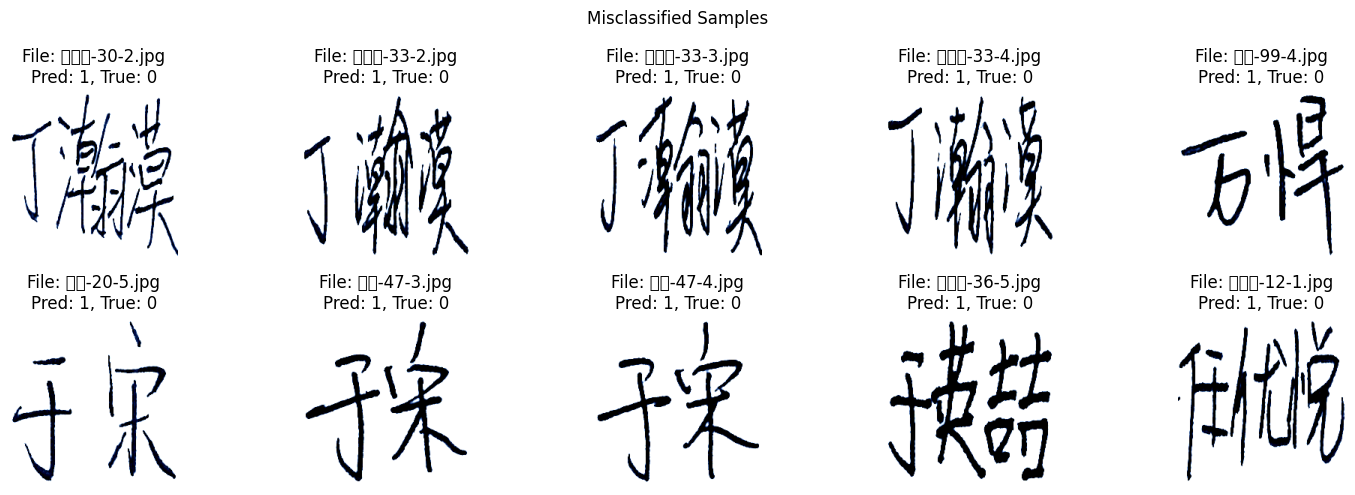

In [54]:
def visualize_misclassified_samples_with_filenames(data_loader, model, num_images=10, title='Misclassified Samples'):
    model.eval()
    images, predictions, true_labels, filenames = [], [], [], []
    misclassified_filenames = []  # Keep track of misclassified filenames
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for input, pred, true, path in zip(inputs, preds, labels, data_loader.dataset.samples):
                if pred != true:
                    images.append(input.cpu().data)
                    predictions.append(pred.item())
                    true_labels.append(true.item())
                    filenames.append(os.path.basename(path[0]))  # Extract filename from path
                    misclassified_filenames.append(os.path.basename(path[0]))  # Track misclassified filenames
                    if len(images) == num_images:
                        break
            if len(images) == num_images:
                break

    # Plotting
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 5))
    fig.suptitle(title)
    axes = axes.flatten()
    for i, (img, pred, true, fname) in enumerate(zip(images, predictions, true_labels, filenames)):
        img = img.numpy().transpose((1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'File: {fname}\nPred: {pred}, True: {true}')
    plt.tight_layout()
    plt.show()

# Call the function to visualize misclassified samples with filenames
pretrained_model = VGG16().to(device)
pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/KAIST/CS470/Project_2/best_model_vgg16.pth'))
pretrained_model.eval()

# Call the function to visualize misclassified samples with filenames
visualize_misclassified_samples_with_filenames(test_loader, pretrained_model)

In [56]:
def list_misclassified_filenames(data_loader, model):
    model.eval()
    misclassified_filenames = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for pred, true, path in zip(preds, labels, data_loader.dataset.samples):
                if pred != true:
                    filename = os.path.basename(path[0])  # Extract filename from path
                    misclassified_filenames.append(filename)

    return misclassified_filenames

# Get the list of misclassified filenames
misclassified_filenames = list_misclassified_filenames(test_loader, model)

print(len(misclassified_filenames))

304


In [59]:
count = 0
for filename in misclassified_filenames:
    # Split the filename using '-' as a delimiter
    parts = filename.split('-')

    # Extract the first part of the split (i.e., the number) and convert it to an integer
    first_number = int(parts[1])

    # Check if the first number is greater than 100
    if first_number > 100:
        count += 1

print("Professional Signatures:", count)

Professional Signatures: 0
